In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:

project_df = pd.read_csv('cellis3_projectcheckin.csv', parse_dates=['Date'])
project_df.set_index('Date', inplace=True)

print("Original dataset shape:", project_df.shape)
print("Time range:", project_df.index.min(), "to", project_df.index.max())

# Narrow down the date range (focus on the pandemic period)
# Let's make sure we keep a sufficient time period based on the sample data we have
if project_df.index.max() > datetime(2020, 6, 1):
    project_df = project_df.loc['2020-02-15':'2020-12-31']
    print("Filtered dataset shape:", project_df.shape)
    print("New time range:", project_df.index.min(), "to", project_df.index.max())

# Forward fill S&P 500 values for trading days
project_df['Value'] = project_df['Value'].ffill()

# Define key mobility metrics we want to focus on (limiting to 3-4 most important)
mobility_cols = [
    'retail_and_recreation_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]

# For mobility metrics, fill missing with rolling mean (7-day window)
for col in mobility_cols:
    project_df[col] = project_df[col].fillna(project_df[col].rolling(7, min_periods=1).mean())

# Create S&P daily returns if not already present
if 'SP500_Daily_Return' not in project_df.columns or project_df['SP500_Daily_Return'].isna().sum() > 0:
    project_df['SP500_Daily_Return'] = project_df['Value'].pct_change()

# Create Market_Up if not already present
if 'Market_Up' not in project_df.columns:
    project_df['Market_Up'] = (project_df['SP500_Daily_Return'] > 0).astype(int)

# Focus on these key variables for our analysis
key_features = [
    'New_Cases_7d_avg',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'New_Cases_lag_7'
]


# Trading days vs. all days
project_df['is_trading_day'] = ~project_df['Value'].isna()

# Split data set into trading days only for analysis
trading_days = project_df[project_df['is_trading_day']].copy()

# Print basic info about the dataset
print("\nSummary statistics for key variables:")
print(trading_days[['Value', 'SP500_Daily_Return', 'New_Cases', 'New_Cases_7d_avg'] + mobility_cols].describe())

# Drop rows with NaN values for analysis
clean_df = trading_days.dropna(subset=['Value', 'SP500_Daily_Return', 'New_Cases_7d_avg'] + mobility_cols)
print("\nClean dataset shape for analysis:", clean_df.shape)



Original dataset shape: (1085, 52)
Time range: 2020-02-17 00:00:00 to 2024-04-12 00:00:00
Filtered dataset shape: (229, 52)
New time range: 2020-02-17 00:00:00 to 2020-12-31 00:00:00

Summary statistics for key variables:
             Value  SP500_Daily_Return      New_Cases  New_Cases_7d_avg  \
count   228.000000          227.000000     228.000000        223.000000   
mean   3208.387281            0.000738   67481.407895      66030.912236   
std     339.132071            0.022746   65945.955685      63118.366556   
min    2237.400000           -0.119841       0.000000          6.000000   
25%    2972.180000           -0.006548   26439.000000      25830.214286   
50%    3257.870000            0.002303   45160.000000      44636.428571   
75%    3444.422500            0.010739   72794.750000      70821.285714   
max    3756.070000            0.093828  255628.000000     234480.857143   

       retail_and_recreation_percent_change_from_baseline  \
count                                    

# 1. Exploratory Data Analysis

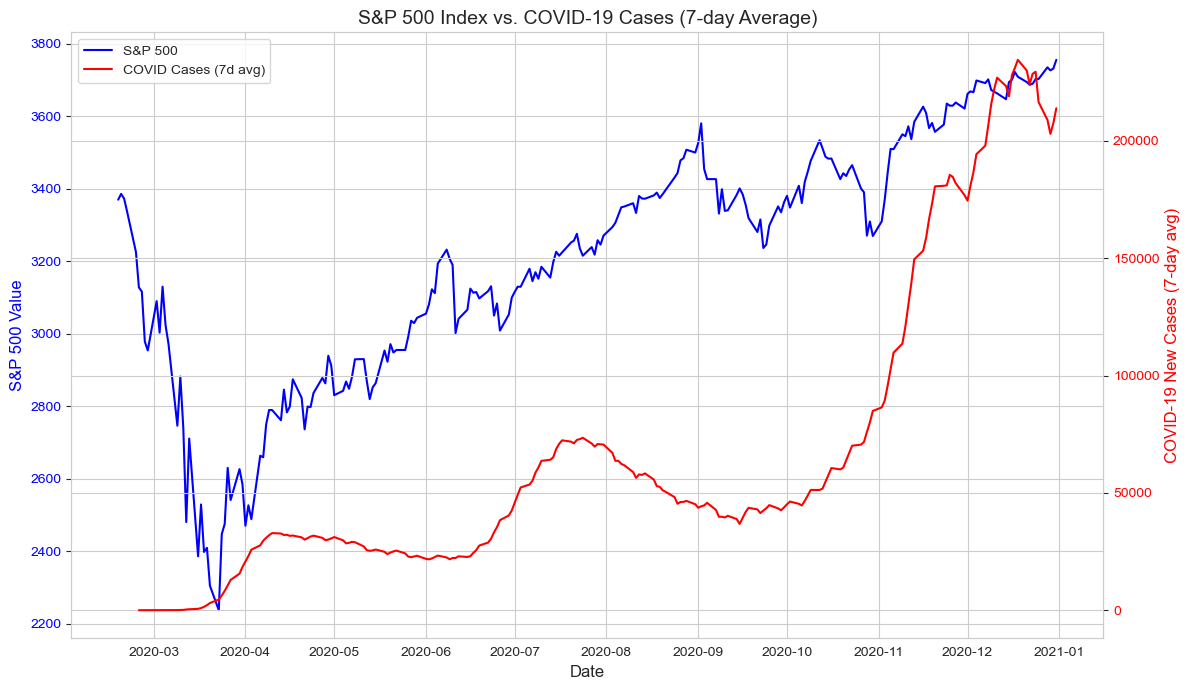

<Figure size 1200x700 with 0 Axes>

In [4]:
# Set up the plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Visualization 1: S&P 500 and COVID-19 Cases
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot S&P 500
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Value', color='blue')
ax1.plot(trading_days.index, trading_days['Value'], 'b-', label='S&P 500')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for COVID cases
ax2 = ax1.twinx()
ax2.set_ylabel('COVID-19 New Cases (7-day avg)', color='red')
ax2.plot(trading_days.index, trading_days['New_Cases_7d_avg'], 'r-', label='COVID Cases (7d avg)')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title('S&P 500 Index vs. COVID-19 Cases (7-day Average)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig('sp500_covid_timeseries.png')


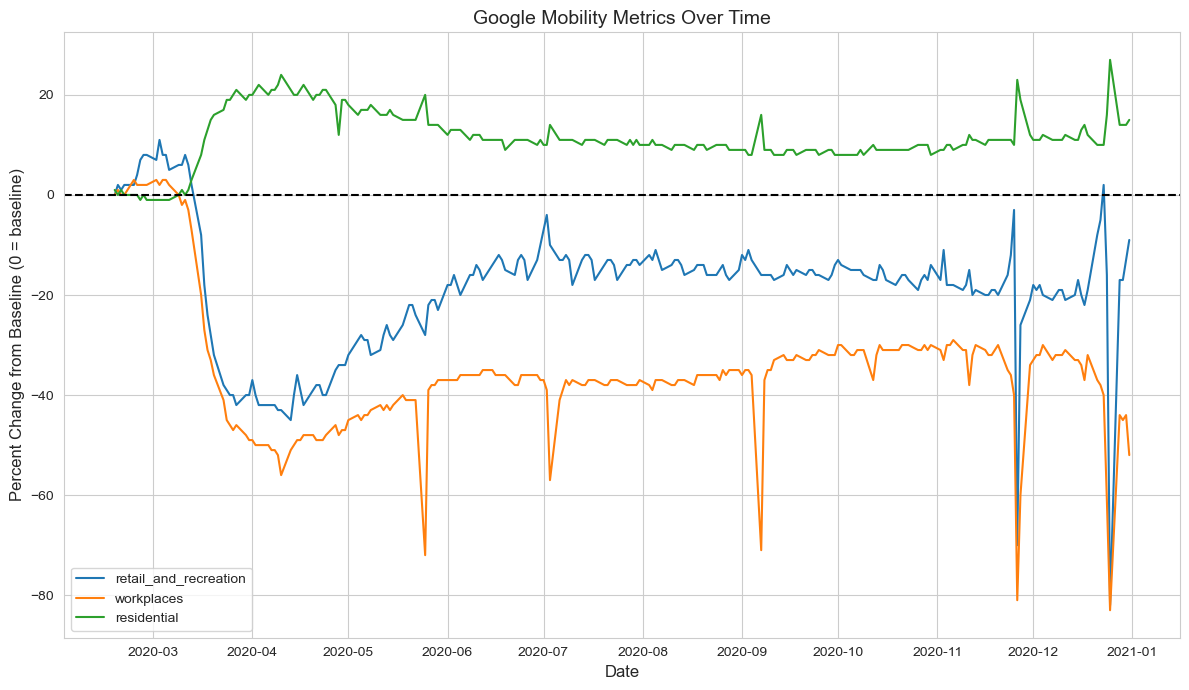

<Figure size 1200x700 with 0 Axes>

In [5]:
# Visualization 2: Key Mobility Metrics Over Time
plt.figure(figsize=(12, 7))
for col in mobility_cols:
    plt.plot(trading_days.index, trading_days[col], label=col.split('_percent')[0])

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Google Mobility Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Change from Baseline (0 = baseline)')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('mobility_trends.png')


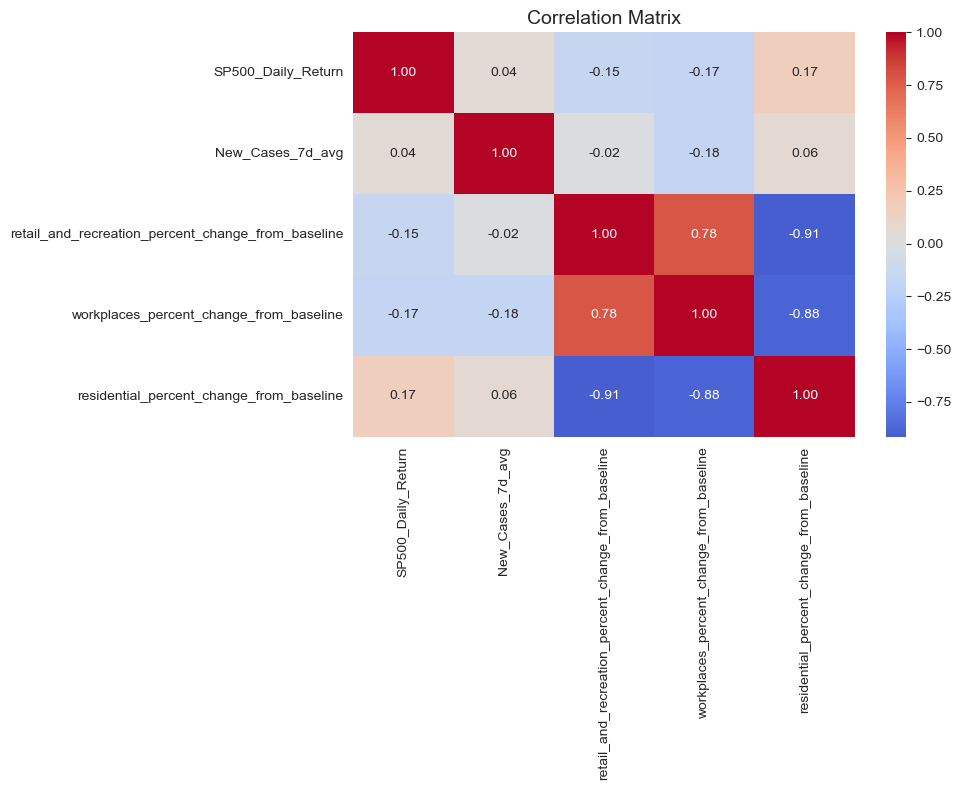

<Figure size 1200x700 with 0 Axes>

In [6]:
# Visualization 3: Correlation Heatmap
corr_cols = ['SP500_Daily_Return', 'New_Cases_7d_avg'] + mobility_cols
corr_matrix = clean_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
#mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')



# 2. Hypothesis Testing

In [8]:
# Test 1: Is there a significant correlation between workplace mobility and S&P returns?
wp_corr, wp_p = stats.pearsonr(
    clean_df['workplaces_percent_change_from_baseline'],
    clean_df['SP500_Daily_Return']
)
print("\nHypothesis 1: Workplace mobility is correlated with S&P 500 returns")
print(f"Correlation: {wp_corr:.3f}, p-value: {wp_p:.4f}")
print(f"Result: {'Reject' if wp_p < 0.05 else 'Fail to reject'} null hypothesis")
print(f"Interpretation: {'Significant' if wp_p < 0.05 else 'No significant'} correlation between workplace mobility and market returns")



Hypothesis 1: Workplace mobility is correlated with S&P 500 returns
Correlation: -0.175, p-value: 0.0090
Result: Reject null hypothesis
Interpretation: Significant correlation between workplace mobility and market returns


In [9]:
# Test 2: Is there a difference in S&P returns on days with high vs. low COVID cases?
# Define high COVID days (above median)
if len(clean_df) > 10:  # Only if we have enough data
    median_cases = clean_df['New_Cases_7d_avg'].median()
    high_covid = clean_df[clean_df['New_Cases_7d_avg'] > median_cases]['SP500_Daily_Return']
    low_covid = clean_df[clean_df['New_Cases_7d_avg'] <= median_cases]['SP500_Daily_Return']

    t_stat, p_val = stats.ttest_ind(high_covid, low_covid, equal_var=False)
    print("\nHypothesis 2: S&P returns differ on high COVID vs. low COVID days")
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    print(f"Mean return on high COVID days: {high_covid.mean()*100:.4f}%")
    print(f"Mean return on low COVID days: {low_covid.mean()*100:.4f}%")
    print(f"Result: {'Reject' if p_val < 0.05 else 'Fail to reject'} null hypothesis")
    print(f"Interpretation: {'Significant' if p_val < 0.05 else 'No significant'} difference in returns between high and low COVID days")



Hypothesis 2: S&P returns differ on high COVID vs. low COVID days
t-statistic: 0.904, p-value: 0.3676
Mean return on high COVID days: 0.2327%
Mean return on low COVID days: -0.0426%
Result: Fail to reject null hypothesis
Interpretation: No significant difference in returns between high and low COVID days


# 3. Time Series

In [11]:
# Prepare data for models - use only the key features that we have
available_features = [col for col in key_features if col in clean_df.columns]

# Prepare data
X = clean_df[available_features]
y_reg = clean_df['SP500_Daily_Return']
y_class = clean_df['Market_Up']

# Create time-based train/test split (first 80% for training, last 20% for testing)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_class_train, y_class_test = y_class.iloc[:split_idx], y_class.iloc[split_idx:]


print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing period: {X_test.index.min()} to {X_test.index.max()}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training period: 2020-02-25 00:00:00 to 2020-10-29 00:00:00
Testing period: 2020-10-30 00:00:00 to 2020-12-31 00:00:00
Training samples: 178, Testing samples: 45


# 4. Regression Models

In [13]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_imputed, y_reg_train)
lr_pred = lr.predict(X_test_imputed)
lr_r2 = r2_score(y_reg_test, lr_pred)
print(f"Linear Regression R² Score: {lr_r2:.4f}")

# Model 2: Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_imputed, y_reg_train)
ridge_pred = ridge.predict(X_test_imputed)
ridge_r2 = r2_score(y_reg_test, ridge_pred)
print(f"Ridge Regression R² Score: {ridge_r2:.4f}")

# Model 3: Random Forest Regressor (handles NaN internally)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_reg_train)  # Use original X_train (no scaling needed for RF)
rf_reg_pred = rf_reg.predict(X_test)
rf_reg_r2 = r2_score(y_reg_test, rf_reg_pred)
print(f"Random Forest Regressor R² Score: {rf_reg_r2:.4f}")

# Feature importance
if rf_reg_r2 > max(lr_r2, ridge_r2):
    print("\nRandom Forest Regressor Feature Importance:")
    reg_importance_df = pd.DataFrame({
        'Feature': available_features,
        'Importance': rf_reg.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(reg_importance_df)

Linear Regression R² Score: -1.3166
Ridge Regression R² Score: -1.3116
Random Forest Regressor R² Score: -3.5285


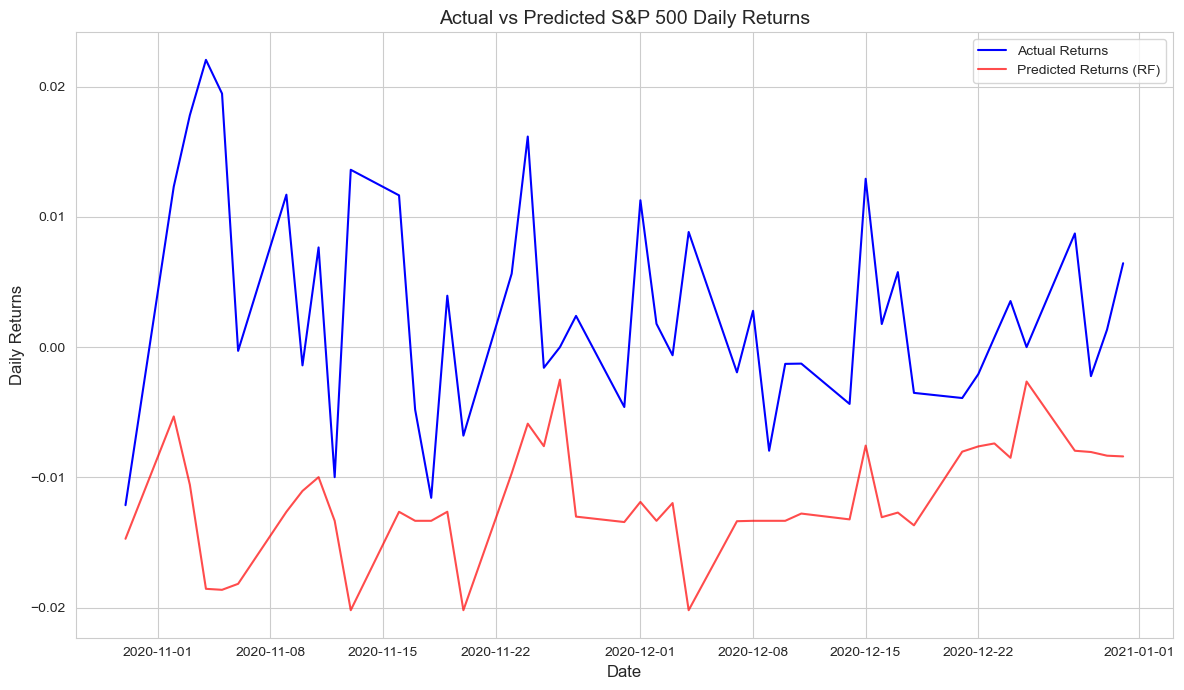

<Figure size 1200x700 with 0 Axes>

In [14]:
# Visualization 4: Actual vs Predicted Returns
plt.figure(figsize=(12, 7))
plt.plot(y_reg_test.index, y_reg_test.values, label='Actual Returns', color='blue')
plt.plot(y_reg_test.index, rf_reg_pred, label='Predicted Returns (RF)', color='red', alpha=0.7)
plt.title('Actual vs Predicted S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('returns_prediction.png')



# 5. Classification Models

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute scaled features (for models that need scaling)
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled)

# Impute original features (for Random Forest which doesn't need scaling)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Function to evaluate and report on classifier performance
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return clf, acc, f1

# Model 1: Logistic Regression (uses scaled+imputed data)
log_reg, log_acc, log_f1 = evaluate_classifier(
    LogisticRegression(random_state=42, max_iter=1000),
    X_train_scaled_imputed, y_class_train, 
    X_test_scaled_imputed, y_class_test,
    "Logistic Regression"
)

# Model 2: Random Forest Classifier (uses original but imputed data)
rf_clf, rf_acc, rf_f1 = evaluate_classifier(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_imputed, y_class_train,
    X_test_imputed, y_class_test,
    "Random Forest"
)

# Model 3: SVM (uses scaled+imputed data)
svm, svm_acc, svm_f1 = evaluate_classifier(
    SVC(random_state=42),
    X_train_scaled_imputed, y_class_train,
    X_test_scaled_imputed, y_class_test,
    "Support Vector Machine"
)


models = {"Logistic Regression": log_acc, "Random Forest": rf_acc, "SVM": svm_acc}
best_model = max(models, key=models.get)
print(f"\nBest classification model: {best_model} with accuracy {models[best_model]:.4f}")

# Feature importance for Random Forest classifier
print("\nRandom Forest Classifier Feature Importance:")
clf_importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)
print(clf_importance_df)

Logistic Regression - Accuracy: 0.5333, F1 Score: 0.6957
Random Forest - Accuracy: 0.4444, F1 Score: 0.0741
Support Vector Machine - Accuracy: 0.5111, F1 Score: 0.3529

Best classification model: Logistic Regression with accuracy 0.5333

Random Forest Classifier Feature Importance:
                                             Feature  Importance
4                                    New_Cases_lag_7    0.290750
0                                   New_Cases_7d_avg    0.286469
1            workplaces_percent_change_from_baseline    0.170935
3  retail_and_recreation_percent_change_from_base...    0.156051
2           residential_percent_change_from_baseline    0.095794


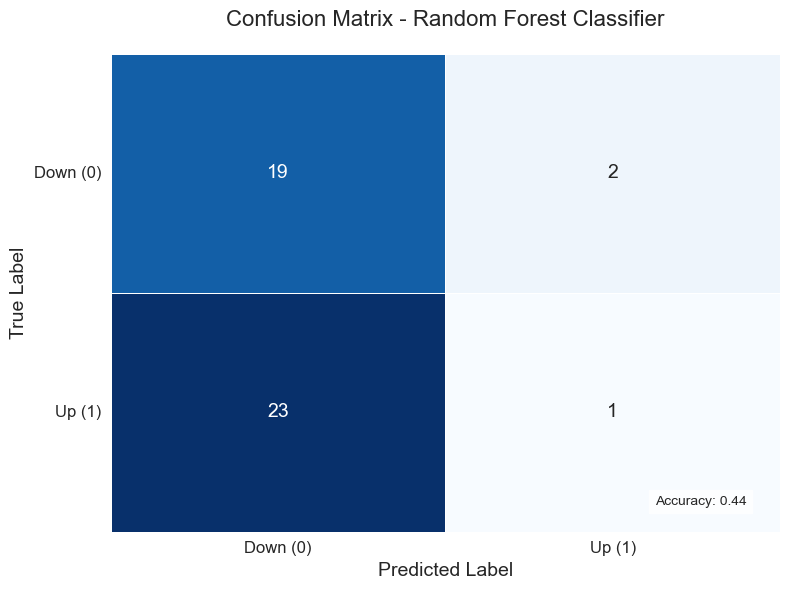

In [17]:
plt.figure(figsize=(8, 6))
rf_preds = rf_clf.predict(X_test_imputed)  # Use the imputed test set
cm = confusion_matrix(y_class_test, rf_preds)

# Enhanced visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, linewidths=.5)

plt.title('Confusion Matrix - Random Forest Classifier', pad=20, fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks([0.5, 1.5], ['Down (0)', 'Up (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Down (0)', 'Up (1)'], fontsize=12, rotation=0)

# Add accuracy to plot
accuracy = np.trace(cm) / float(np.sum(cm))
plt.text(0.95, 0.05, f'Accuracy: {accuracy:.2f}',
         ha='right', va='bottom',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

# 6. Time Series Forecasting

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math

# Prepare data for forecasting - we'll forecast the S&P 500 value
sp500_series = clean_df['Value']

# Split into train and test
train_size = int(len(sp500_series) * 0.8)
train, test = sp500_series[:train_size], sp500_series[train_size:]

print(f"Time Series Forecasting period: {test.index.min()} to {test.index.max()}")
print(f"Training data points: {len(train)}, Testing data points: {len(test)}")


Time Series Forecasting period: 2020-10-30 00:00:00 to 2020-12-31 00:00:00
Training data points: 178, Testing data points: 45


                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                  179
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 5)   Log Likelihood                -936.598
Date:                             Fri, 02 May 2025   AIC                           1893.196
Time:                                     20:31:14   BIC                           1924.554
Sample:                                 02-25-2020   HQIC                          1905.921
                                      - 10-30-2020                                         
Covariance Type:                               opg                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
New_Cases_7d_avg          

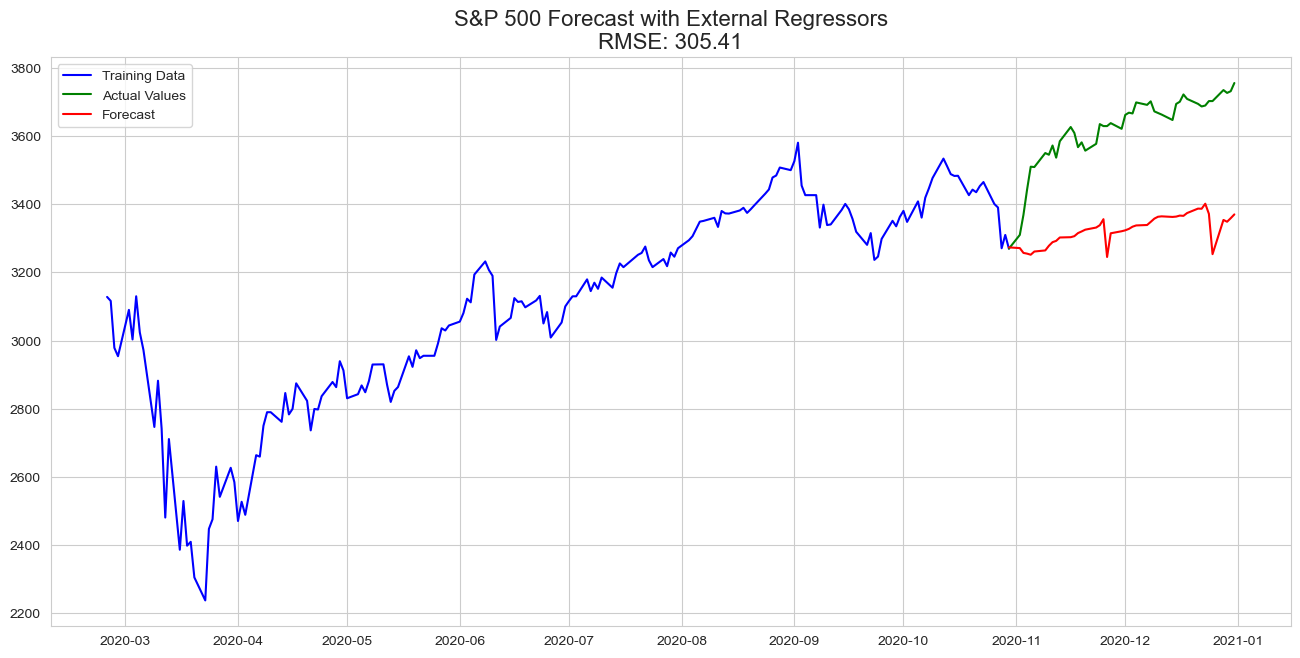

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

# Prepare data
sp500 = clean_df['Value'].asfreq('B').ffill()
features = clean_df[['New_Cases_7d_avg', 
                    'workplaces_percent_change_from_baseline',
                    'retail_and_recreation_percent_change_from_baseline']].asfreq('B').ffill()

# Align and scale features
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features),
                             index=features.index,
                             columns=features.columns)

# Train-test split (80-20)
split_date = sp500.index[int(len(sp500)*0.8)]
train_y, test_y = sp500[:split_date], sp500[split_date:]
train_x, test_x = features_scaled[:split_date], features_scaled[split_date:]


order = (2, 1, 2)  # Start with these parameters
seasonal_order = (1, 0, 1, 5)  # Weekly seasonality

model = SARIMAX(train_y,
               exog=train_x,
               order=order,
               seasonal_order=seasonal_order,
               enforce_stationarity=False,
               enforce_invertibility=False)

results = model.fit(disp=0)
print(results.summary())

# Forecast using test period features
forecast = results.get_forecast(steps=len(test_y), exog=test_x)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, forecast_values))
print(f"\nSARIMAX RMSE: {rmse:.2f}")


plt.figure(figsize=(16, 10))

# Main plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.plot(train_y.index, train_y, label='Training Data', color='blue')
ax1.plot(test_y.index, test_y, label='Actual Values', color='green')
ax1.plot(test_y.index, forecast_values, label='Forecast', color='red')
ax1.set_title(f'S&P 500 Forecast with External Regressors\nRMSE: {rmse:.2f}', fontsize=16)
ax1.legend(loc='upper left')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


In [25]:
print("\n\n============= SUMMARY OF FINDINGS =============")
print("1. Data covered the period from", clean_df.index.min(), "to", clean_df.index.max())
print(f"2. Best regression model: Random Forest (R² = {rf_reg_r2:.4f})")
print(f"3. Best classification model: {best_model} (Accuracy = {models[best_model]:.4f})")

if 'arima_rmse' in locals():
    print(f"4. Time series forecasting: ARIMA RMSE = {rmse:.2f}")

print("\nTop predictive features:")
print(clf_importance_df.head(3))

print("\nKey correlations with S&P 500 Returns:")
for col in mobility_cols + ['New_Cases_7d_avg']:
    if col in clean_df.columns:
        corr = clean_df[['SP500_Daily_Return', col]].corr().iloc[0, 1]
        print(f"{col}: {corr:.3f}")

print("\nThis analysis explores the relationship between COVID-19 metrics, mobility data, and S&P 500 performance.")
print("We've examined correlations, tested hypotheses, built predictive models, and conducted time series forecasting.")
print("The findings suggest that mobility metrics have some predictive power for market movements.")




============= SUMMARY OF FINDINGS =============
1. Data covered the period from 2020-02-25 00:00:00 to 2020-12-31 00:00:00
2. Best regression model: Random Forest (R² = -3.5285)
3. Best classification model: Logistic Regression (Accuracy = 0.5333)
4. Time series forecasting: ARIMA RMSE = 305.41

Top predictive features:
                                   Feature  Importance
4                          New_Cases_lag_7    0.290750
0                         New_Cases_7d_avg    0.286469
1  workplaces_percent_change_from_baseline    0.170935

Key correlations with S&P 500 Returns:
retail_and_recreation_percent_change_from_baseline: -0.155
workplaces_percent_change_from_baseline: -0.175
residential_percent_change_from_baseline: 0.168
New_Cases_7d_avg: 0.043

This analysis explores the relationship between COVID-19 metrics, mobility data, and S&P 500 performance.
We've examined correlations, tested hypotheses, built predictive models, and conducted time series forecasting.
The findings sugge